<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">TFM - Previsión de demanda mediante uso de técnicas de machine learning
</p>
<p style="margin: 0; text-align:right;">Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Carlos Pérez Cebrián</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

### LSTM  (Long Short-Term Memory) 

Aplicación del modelo de tipo red neuronal, LSTM  (Long Short-Term Memory), para predecir la demanda de productos en función de una serie de factores contextuales y temporales. 

Pasos seguidos:

- Preparar los daots: Escalar variables numéricas y codificar las categóricas.
- Redimensionado de los datos.
- Crea un modelo secuencial con una capa LSTM seguida de una capa de dropout para regularización.
- Entrenar modelo: durante 50 épocas, optimizador Adam y función de pérdida mean_squared_error.
- Predecir los valores de udsVenta sobre el conjunto de prueba
- Evaluar el modelo, métricas MSE, MAE y R².


Cargamos las siguientes librerías necesarias:

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score #metricas
from keras.layers import Input #capa input - dimensiones
import matplotlib.pyplot as plt

Cargar el conjunto de datos:
(Nota: el conjunto de datos es el resultado de una fase de exploración, analisis y preparación previa.

In [2]:
# Cargar el archivo CSV con los datos de ventas
file_path = "Data/VentasRdo.csv"
file_path = "Data/VentasRdo_10productos.csv"
df = pd.read_csv(file_path, parse_dates=['idSecuencia'])

In [3]:
# Tratamiento de variables categóricas y numéricas
categorical_columns = ['producto', 'bolOpen', 'EnPromocion', 'diasemana', 'semana']
numerical_columns = ['anyomes', 'media_7_dias', 'media_30_dias', 'venta_lag_1', 'venta_lag_7', 'venta_lag_30']

# Escalado de variables numéricas
scaler = StandardScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# OneHotEncoding de variables categóricas
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# Definir variables independientes (X) y dependientes (y)
X = df_encoded.drop(columns=['udsVenta', 'idSecuencia'])
y = df_encoded['udsVenta']

# Convertir a arrays de numpy
X = X.values
y = y.values

# Redimensionar X para que sea compatible con LSTM [samples, time steps, features]
# Aquí estamos asumiendo que los datos son secuenciales de un solo paso temporal
X = X.reshape((X.shape[0], 1, X.shape[1]))

In [4]:
# Dividir el conjunto de datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Dimensiones de X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")

Dimensiones de X_train: (5608, 1, 74), X_test: (1402, 1, 74), y_train: (5608,), y_test: (1402,)


In [5]:
#modelo LSTM
model = Sequential()

# Capa de entrada explícita (Input Layer)
model.add(Input(shape=(X.shape[1], X.shape[2])))

# Capa LSTM
model.add(LSTM(units=50, return_sequences=False))

# Capa Dropout
model.add(Dropout(0.2))

# Capa densa
model.add(Dense(units=1))

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        25,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,051 (97.86 KB)

 Trainable params: 25,051 (97.86 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1.8643 - mae: 1.0962 - val_loss: 0.5637 - val_mae: 0.6045
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5707 - mae: 0.6054 - val_loss: 0.5182 - val_mae: 0.5787
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5487 - mae: 0.5944 - val_loss: 0.5070 - val_mae: 0.5657
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5234 - mae: 0.5751 - val_loss: 0.5025 - val_mae: 0.5614
Epoch 5/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5155 - mae: 0.5713 - val_loss: 0.4960 - val_mae: 0.5561
Epoch 6/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4938 - mae: 0.5571 - val_loss: 0.4945 - val_mae: 0.5531
Epoch 7/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5066 - mae: 0.5614 - val_loss: 0.4924 - val_mae: 0.5478
Epoch 8/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4999 - mae: 0.5541 - val_loss: 0.4916 - val_mae: 0.5481
Epoch 9/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - lo

In [7]:
# Predicciones
y_pred = model.predict(X_test)

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [8]:
# Métricas
rmse = mean_squared_error(y_test, y_pred, squared=False)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R2: {r2}')

RMSE: 0.7120750797120078
MSE: 0.5070509191468622
MAE: 0.5540898074254245
R2: 0.5116746459576011


La gráfica de la pérdida muestra cómo el modelo mejora a lo largo del tiempo durante el proceso de entrenamiento y validación

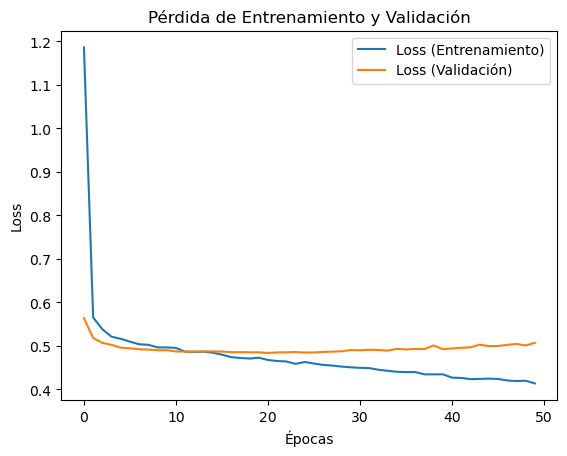

In [9]:
# Gráfica de la pérdida durante el entrenamiento y validación
plt.plot(history.history['loss'], label='Loss (Entrenamiento)')
plt.plot(history.history['val_loss'], label='Loss (Validación)')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Pérdida de Entrenamiento y Validación')
plt.legend()
plt.show()


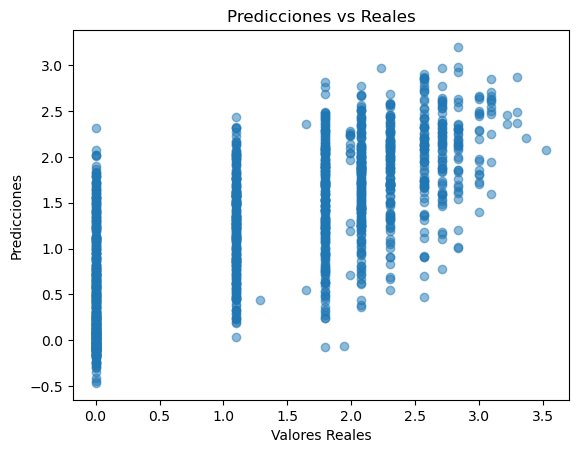

In [10]:
# Comparar predicciones vs valores reales
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Reales')
plt.show()

Pérdida de entrenamiento (loss): Decrece de forma constante, lo cual indica una mejora continua, es decir, que el modelo está aprendiendo y ajustando sus parámetros. Empezó en 1.87 y terminó en 0.40.

Pérdida de validación (val_loss): También disminuye en general, pero hay algo de fluctuación en los valores después de algunas iteraciones, dando señales que el modelo está comenzando a sobreajustarse (overfitting). A partir de la época 25, la pérdida de validación parece estabilizarse en torno a 0.49-0.50.

MSE: 0.5051069011736486
MAE: 0.5510397063746614
R2: 0.5135468706774213

Las métricas indican que tiene un desempeño moderado, pero hay margen para mejorar mediante la optimización de hiperparámetros
(número de capas, tamaño de las unidades LSTM, tasa de aprendizaje, etc.).
